In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import torchvision
from torchvision import datasets, models, transforms

In [3]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict

In [4]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
import Datasets.ModelData as md
from Transforms.ImageTransforms import *
import util

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [7]:
def print_example_from_data(im, bbs, cats, ax=None):
    if ax is not None:
        show_img(im, ax=ax)
    else:
        ax = show_img(im)
        
    for bb, cat in zip(util.partition(bbs, 4), cats):
        bb = center_to_hw(bb)      
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], cat)

In [8]:
DATA_PATH = Path('C:/fastai/courses/dl2/data/road_damage_dataset')
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'
MULTIBB_CSV_PATH = DATA_PATH/'bb.csv'

In [9]:
files, mcs = ImageData.parse_csv_data(MULTICLASS_CSV_PATH)

In [10]:
files, mbbs = ImageData.parse_csv_data(MULTIBB_CSV_PATH)

In [11]:
mbbs = [corners_to_center([int(x) for x in mbb.split(' ')]) for mbb in mbbs]

In [12]:
files = [DATA_PATH/file for file in files]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


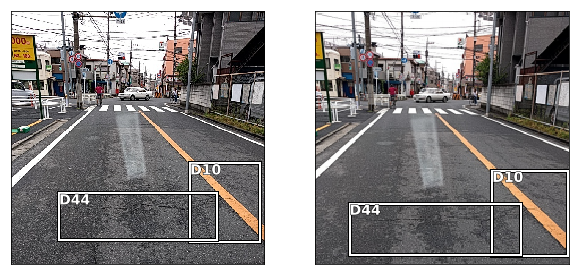

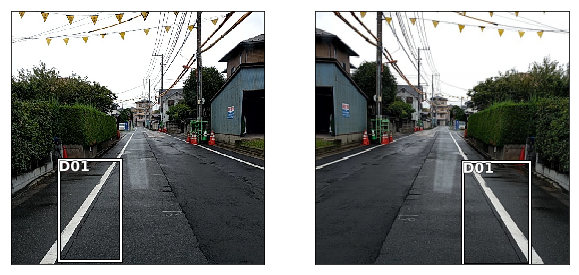

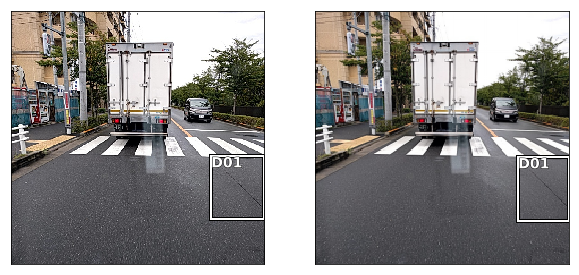

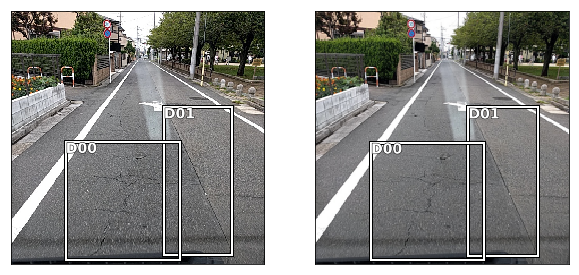

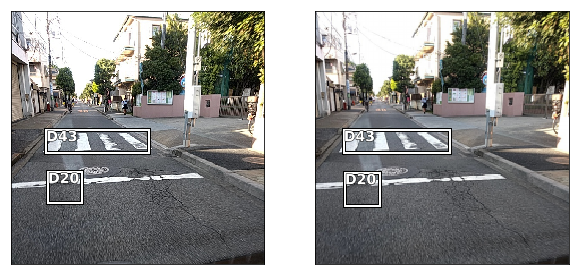

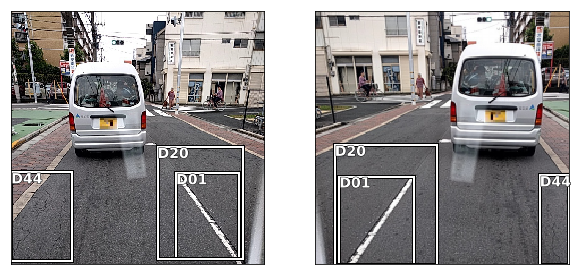

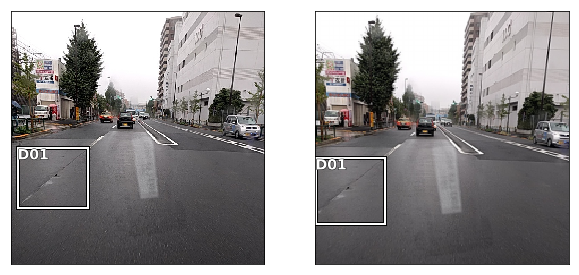

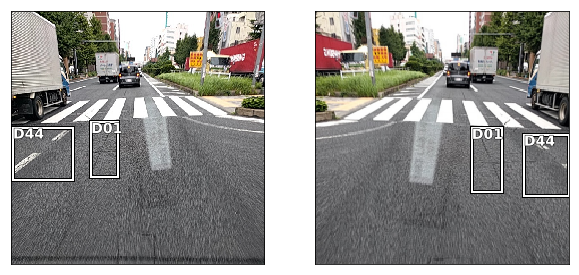

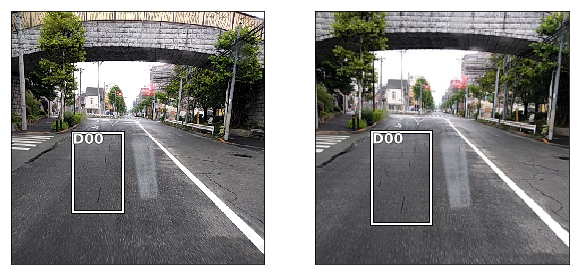

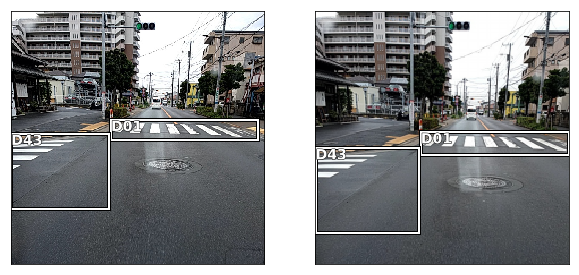

In [14]:
labels = [md.StructuredLabel([(bb, md.LabelType.BOUNDING_BOX), (cat, md.LabelType.CATEGORY)]) for bb, cat in zip(mbbs, mcs)]

test_tfms = TransformList([
    RandomScale(224, 1.2),
    RandomCrop(224),
    RandomHorizontalFlip()
])

dataset = ImageData.ImageDataset(files, labels, test_tfms)

for i in range(10):
    f, ax = plt.subplots(1,2, figsize=(10, 10))
    print_example_from_data(ImageData.open_image(DATA_PATH/files[i]), labels[i][0][0], labels[i][1][0].split(" "), ax[0])
    im, new_label, *_ = dataset[i]
    print_example_from_data(im, new_label[0][0], new_label[1][0].split(" "), ax[1])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False) 